# Dogs Vs Cats Classification using Tensorflow and Keras with VGG16 Transfer Learning

By caching the early layers of the convnet model, we can speed up the last layer calculations when trying various fully connected last layers. However, we have no data augmentations (on-the-fly) here

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import applications, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input

## Define constants

In [3]:
# dimensions of our images
img_width, img_height = 150,150 #224,224 for VGG16 by default

PATH = 'data/dogscats_small/'
train_data_dir = f'{PATH}train/'
validation_data_dir = f'{PATH}validation/'
test_data_dir = f'{PATH}test/'
epochs = 50
batch_size = 16

In [4]:
# value stored in /users/<user>/keras/.keras.json file
# "channels_last" for tensorflow

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Helper functions

In [5]:
# ensure the child directories are non-empty and contain jpg files
def rand_img_from_child_dirs(dir_path):
    
    dirs =  [directory for directory in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,directory)) 
             and not directory.startswith('.')]
    random_dir = np.random.choice(dirs)
    random_dir_path = os.path.join(dir_path,random_dir)
    files =  [file for file in os.listdir(random_dir_path) if file.endswith('.jpg')]
    random_img = np.random.choice(files)

    return os.path.join(random_dir_path,random_img)

In [6]:
def plot_training_history(log):
    acc = log.history['acc']
    val_acc = log.history['val_acc']
    loss = log.history['loss']
    val_loss = log.history['val_loss']

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, 'b', label='Training acc')
    plt.plot(epoch_range, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, 'b', label='Training loss')
    plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Build pre-trained model (VGG16)

In [7]:
conv_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

## Calculate and cache the bottleneck features

In [8]:
os.makedirs('tmp', exist_ok=True)

# no data augmentation if we want to cache
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,# this means our generator will only yield batches of data, no labels
    shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
                    # hence easier to generate train labels later

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,# this means our generator will only yield batches of data, no labels
    shuffle=False) # our data will be in order, so all first 400 images will be cats, then 400 dogs
                    # hence easier to generate validation labels later

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
bottleneck_features_train = conv_model.predict_generator(train_generator, 
                                                         train_generator.n // batch_size)
bottleneck_features_validation = conv_model.predict_generator(validation_generator, 
                                                              validation_generator.n // batch_size)

np.save('tmp/vgg16_bottleneck_features_train.npy', bottleneck_features_train)
np.save('tmp/vgg16_bottleneck_features_validation.npy', bottleneck_features_validation)

## Load the cached calculations

In [13]:
# for train_labels and validation_labels we manually generate first half as 0 and the second half as 1
# hence no shuffling during generation earlier

train_data = np.load('tmp/vgg16_bottleneck_features_train.npy')
train_labels = np.array([0] * (train_generator.n // 2) + [1] * (train_generator.n // 2)) 

validation_data = np.load('tmp/vgg16_bottleneck_features_validation.npy')
validation_labels = np.array([0] * (validation_generator.n // 2) + [1] * (validation_generator.n // 2))

## Train top model (last layer - fully connected)

In [119]:
def build_last_layer(input_shape, build_with_sequential=True, fc_type=1):
    
    # build_with_sequential = True # else it would be functional
    # fc_type = 1,2, 3

    if build_with_sequential:
        model = Sequential()

        if fc_type == 1:
            model.add(Flatten(input_shape=input_shape))
            model.add(Dense(256, activation='relu')) # Keras blog version
            model.add(Dropout(0.5))
        elif fc_type == 2:
            model.add(Flatten(input_shape=input_shape))
            model.add(Dense(1024, activation='relu')) # Magnus Pedersen Version
            model.add(Dropout(0.5))
        else:
            # fastai jeremy's version
            model.add(GlobalAveragePooling2D(input_shape=input_shape))
            model.add(Dense(1024, activation='relu'))

        model.add(Dense(1, activation='sigmoid'))

    else:
        a = Input(shape=input_shape)
        
        if fc_type == 1:
            x = Flatten()(a)
            x = Dense(256, activation='relu')(x)
            x = Dropout(0.5)(x)
        elif fc_type == 2:
            x = Flatten()(a)
            x = Dense(1024, activation='relu')(x)
            x = Dropout(0.5)(x)
        else:
            # fastai jeremy's version
            x = GlobalAveragePooling2D()(a)
            x = Dense(1024, activation='relu')(x)

        b = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=a, outputs=b)
        
    return model

In [120]:
del last_layer_model

In [121]:
build_with_sequential = True # else it would be functional
fc_type = 1

last_layer_model = build_last_layer(train_data.shape[1:],
                                    build_with_sequential=build_with_sequential, 
                                    fc_type=fc_type)

In [122]:
# print(type(last_layer_model))
# last_layer_model.summary()

In [123]:
# compile must be called after the trainable are set
last_layer_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [124]:
%%time
training_log = last_layer_model.fit(train_data, train_labels,
                     epochs=epochs,
                     batch_size=batch_size,       
                     validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 2s 751us/step - loss: 7.9362 - acc: 0.5015 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/50
2000/2000 [==============================] - 1s 369us/step - loss: 7.4804 - acc: 0.5285 - val_loss: 4.6725 - val_acc: 0.6975
Epoch 3/50
2000/2000 [==============================] - 1s 366us/step - loss: 1.8703 - acc: 0.8745 - val_loss: 0.7323 - val_acc: 0.9487
Epoch 4/50
2000/2000 [==============================] - 1s 364us/step - loss: 1.1732 - acc: 0.9235 - val_loss: 0.7318 - val_acc: 0.9487
Epoch 5/50
2000/2000 [==============================] - 1s 371us/step - loss: 1.0377 - acc: 0.9305 - val_loss: 1.9323 - val_acc: 0.8762
Epoch 6/50
2000/2000 [==============================] - 1s 370us/step - loss: 1.1018 - acc: 0.9275 - val_loss: 1.0273 - val_acc: 0.9325
Epoch 7/50
2000/2000 [==============================] - 1s 359us/step - loss: 0.6802 - acc: 0.9555 - val_loss: 0.4589 - val_acc: 0.9675
E

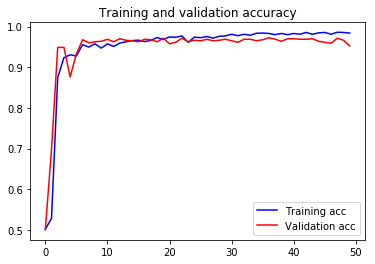

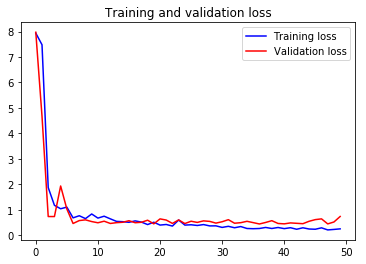

In [125]:
plot_training_history(training_log)

## Save model

### Save as full model

In [126]:
os.makedirs(f'{PATH}models/', exist_ok=True)

In [127]:
last_layer_model.save(f'{PATH}/models/vgg16_precached_bottleneck_fc_model.h5')

### Save as architecture definition (json) + weights value

In [128]:
model_json = last_layer_model.to_json()

with open(f'{PATH}/models/vgg16_precached_bottleneck_fc_arch.json', 'w') as json_file:
    json_file.write(model_json)
    
last_layer_model.save_weights(f'{PATH}/models/vgg16_precached_bottleneck_fc_weights.h5')

## Load model to predict test data

In [129]:
# both options should return the same model but we may want to 
# change the weights using those obtained from training
load_from_model_file = True

if load_from_model_file:
    test_last_layer_model = load_model(f'{PATH}/models/vgg16_precached_bottleneck_fc_model.h5')
else:
    json_file = open(f'{PATH}/models/vgg16_precached_bottleneck_fc_arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    test_last_layer_model = model_from_json(loaded_model_json)

    test_last_layer_model.load_weights(f'{PATH}/models/vgg16_precached_bottleneck_fc_weights.h5')

## Predict on single image

data/dogscats_small/validation/cats/cat.1104.jpg


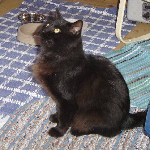

In [130]:
rand_img_path = rand_img_from_child_dirs(validation_data_dir)
rand_img = image.load_img(rand_img_path, target_size=(img_width, img_height))    
rand_dog_cat = 'dog' if 'validation/dogs' in rand_img_path else 'cat'

print(rand_img_path)
rand_img

In [131]:
x_test = image.img_to_array(rand_img)
x = preprocess_input(x_test)
x_test = np.expand_dims(x_test, axis=0) # increase dimension so that can be fed into model

In [132]:
bottleneck_features = conv_model.predict(x_test)

In [133]:
if build_with_sequential:
    pred = np.asscalar(np.squeeze(test_last_layer_model.predict_classes(bottleneck_features)))
    proba = np.asscalar(np.squeeze(test_last_layer_model.predict_proba(bottleneck_features)))
    print(pred, proba)

0 0.0


In [134]:
prob = np.asscalar(np.squeeze(test_last_layer_model.predict(bottleneck_features)))
prob

0.0

In [135]:
if build_with_sequential:
    res = 'dog' if pred==1 else 'cat'
else:
    res = 'dog' if prob>=0.5 else 'cat'
    
pct = round(prob*100,2)
if res is 'cat':
    pct = 100 - pct 

print('The model is ' + str(pct) + '% sure this is a ' + res)

The model is 100.0% sure this is a cat


## Predict on batch of test images

Unlike validation data, these are never seen or tested before

In [136]:
def predict(data_dir, base_model, last_layer_model):
    preds = []
    
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = preprocess_input(x)
        x = np.expand_dims(x, axis=0)
        
        features = base_model.predict(x)
        if build_with_sequential:
            pred = np.asscalar(np.squeeze(last_layer_model.predict_classes(features)))
        else:
            pred = np.asscalar(np.squeeze(last_layer_model.predict(features)))
        preds.append(pred)
        
    return np.array(preds)

In [137]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

In [138]:
pred_dogs = predict(dog_test_dir, conv_model, test_last_layer_model)

In [139]:
pred_cats = predict(cat_test_dir, conv_model, test_last_layer_model)

In [140]:
if build_with_sequential:
    cat_acc = (1-pred_cats.mean())*100
    dog_acc = pred_dogs.mean()*100
else:
    cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
    dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100

overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 98.90%
Dog Prediction Accuracy: 90.50%
Overall Accuracy: 94.70%


### Results Comparison

#### Baseline

- Cat Prediction Accuracy: 77.70%
- Dog Prediction Accuracy: 81.80%

#### All with 10 epochs

Seq_1
- Cat Prediction Accuracy: 98.60%
- Dog Prediction Accuracy: 91.60%
- Overall Accuracy: 95.10%

Seq_2
- Cat Prediction Accuracy: 99.10%
- Dog Prediction Accuracy: 81.40%
- Overall Accuracy: 90.25%

Seq_3
- Cat Prediction Accuracy: 93.00%
- Dog Prediction Accuracy: 97.80%
- Overall Accuracy: 95.40%

Func_1
- Cat Prediction Accuracy: 98.90%
- Dog Prediction Accuracy: 88.70%
- Overall Accuracy: 93.80%

Func_2
- Cat Prediction Accuracy: 97.20%
- Dog Prediction Accuracy: 91.70%
- Overall Accuracy: 94.45%

Func_3
- Cat Prediction Accuracy: 98.70%
- Dog Prediction Accuracy: 91.60%
- Overall Accuracy: 95.15%

#### All with 50 epochs

Seq_1
- Cat Prediction Accuracy: 98.90%
- Dog Prediction Accuracy: 90.50%
- Overall Accuracy: 94.70%

Seq_2
- Cat Prediction Accuracy: 96.40%
- Dog Prediction Accuracy: 94.80%
- Overall Accuracy: 95.60%

Seq_3
- Cat Prediction Accuracy: 96.90%
- Dog Prediction Accuracy: 95.40%
- Overall Accuracy: 96.15%


Func_1


Func_2


Func_3
- Cat Prediction Accuracy: 96.40%
- Dog Prediction Accuracy: 96.40%
- Overall Accuracy: 96.40%
